In [3]:
import pyvisa as visa
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import time
from edes.modules.detection.detection_utils import plot, plot_ax, big_plt_font

big_plt_font()
rm = visa.ResourceManager()
## uncomment the following if full address not known
# instruments = rm.list_resources() 
# usb = list(filter(lambda x: 'USB' in x, instruments))
SSA = rm.open_resource('TCPIP::192.168.169.161::INSTR')
print(SSA.query("*IDN?"))

Siglent Technologies,SSA3032X-R,SSA5PA1Q800415,3.2.2.6.0R10



In [8]:
freq_center = 186.648 # MHz
freq_span = 0.5 # MHz
RBW_AUTO = 0 #1-ON, 0-OFF
VBW_AUTO = 1 #1-ON, 0-OFF
SWT_AUTO = 1 #1-ON, 0-OFF
VBW_RBW_RAT = 10 
RBW = 10 #kHz
VBW = 100 #kHz
SWT = 1 #ms
N_AVG = 100

In [12]:
# Configure frequency
SSA.write("SENS:FREQ:CENT " + str(freq_center) + " MHz")
SSA.write("SENS:FREQ:SPAN " + str(freq_span) + " MHz")

# Configure bandwidths and sweep time
SSA.write("SENS:BWID:AUTO " + str(RBW_AUTO))
SSA.write("SENS:BWID:VID:AUTO " + str(VBW_AUTO))
SSA.write("SENS:SWE:TIME:AUTO " + str(SWT_AUTO))
SSA.write("SENS:BWID:VID " + str(VBW) + " kHz")
SSA.write("SENS:BWID " + str(RBW) + " kHz")
SSA.write("SENS:BWID:VID:RAT " + str(VBW_RBW_RAT))
SSA.write("SENS:SWE:TIME " + str(SWT) + " ms")

# Set sweep mode to FFT
SSA.write(":SWEep:MODE FFT")

# Set averaging ON and number of averages = 100
SSA.write(":AVERage:TRACe1:COUNt 1")
SSA.write(f":AVERage:TRACe3:COUNt {N_AVG}")
time.sleep(SWT*1e-3*N_AVG)

# Set power unit to dBm
SSA.write("UNIT:POW DBM")

14

In [50]:
data_arr_B = 0 
for _ in range(N_AVG):
    data_str_A = SSA.query(":TRACe1:DATA?")
    data_arr_A = np.array([float(val) for val in data_str_A.split(',')])
    data_arr_B += 10**(data_arr_A/10) / N_AVG
    time.sleep(SWT*1e-3*100)
SSA.write(":AVERage:TRAC3:CLEar")
while int(SSA.query(":AVERage:TRACe3?")) < N_AVG: 
    continue
data_str_C = SSA.query(":TRACe3:DATA?")
data_arr_C = np.array([float(val) for val in data_str_C.split(',')])

In [60]:
now = time.time()
SSA.write(":AVERage:TRAC3:CLEar")
while int(SSA.query(":AVERage:TRACe3?")) < N_AVG: 
    continue
data_str_C = SSA.query(":TRACe3:DATA?")
data_arr_C = np.array([float(val) for val in data_str_C.split(',')])
now2 = time.time()
print(now2-now)

5.671111345291138


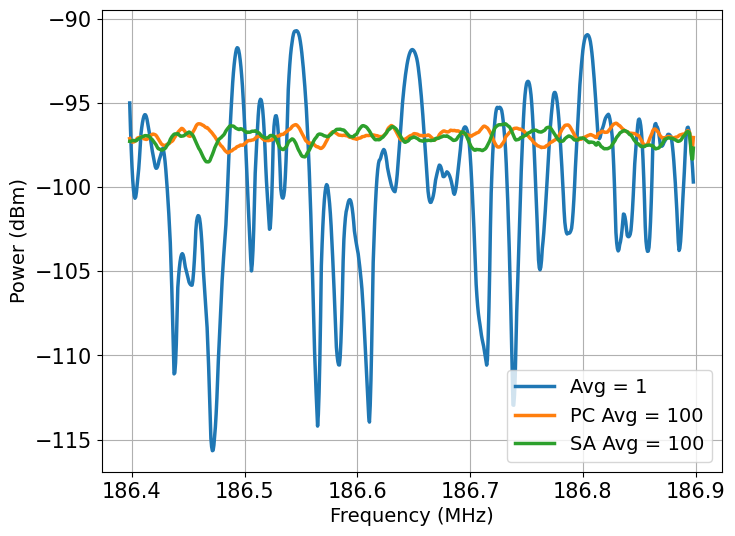

In [61]:
# Number of points in the trace
num_points = len(data_arr_A)

# Generate frequency axis in MHz
freq_start = freq_center - freq_span / 2
freq_stop  = freq_center + freq_span / 2
freq_axis = np.linspace(freq_start, freq_stop, num_points)

# --- Plot ---
plt.figure(figsize=(8,6))
plot(freq_axis, data_arr_A, label="Avg = 1")
# plot(freq_axis, data_arr_B, label="Average = 1")
plot(freq_axis, 10*np.log10(data_arr_B), label="PC Avg = 100")
plot(freq_axis, data_arr_C, label="SA Avg = 100")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
SSA.write(":INSTrument VNA")
SSA.write(":INITiate:IMMediate")
SSA.write(":FORMat:TRACe:DATA ASCii")
data_str_C = SSA.query(":TRAC1:DATA?")
data_arr_C = np.array([float(val) for val in data_str_C.split(',')])

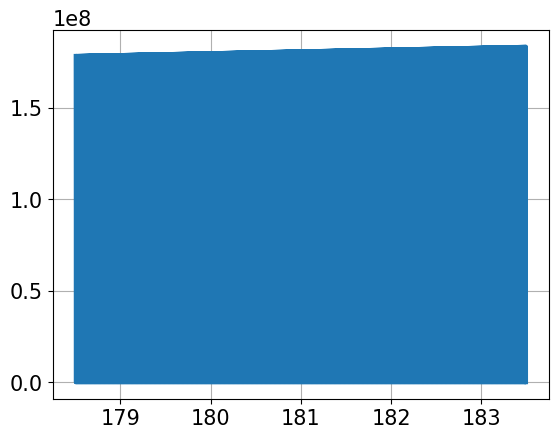

In [19]:
freq_start = 178.5 
freq_stop = 183.5 
f = np.linspace(freq_start, freq_stop, len(data_arr_C)) 
plot(f, data_arr_C)

In [105]:
vna = SSA

# Make sure VNA mode is active
vna.write(":INSTrument:SELect VNA")
vna.write(":INITiate:IMMediate")
 
for form in ['MLOGarithmic', 'Phase']:
    vna.write(f":CALCulate1:FORMat {form}")
    data_str = vna.query(":CALCulate1:DATA:FDATa?")
    data = np.array(data_str.strip().split(','), dtype=float)
    # sleep(1)
    
    # f = data[0::2] 
    # data = data[1::2]
    if form == 'MLOGarithmic': 
        f, mag = data[0::2], data[1::2]
    else: 
        f2, phase = data[0::2], data[1::2]

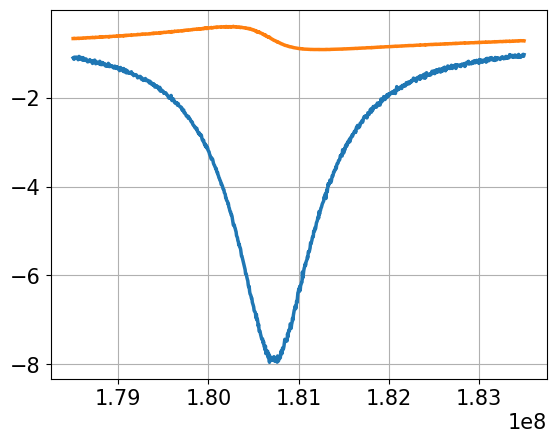

In [107]:
plot(f, mag)
plot(f, np.exp(1j*phase/180*np.pi).real)